In [2]:
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import pyfits
import scipy
from scipy import signal
import scipy.io

from src import pyBSS
from src import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 3 astro images of size [256, 256]
astro_images = pyfits.open('../Data/AstroImages.fits')[0].data


/usr/local/lib/python3.4/dist-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (789312) is smaller than the expected size (792000)
  (self.size, pos))


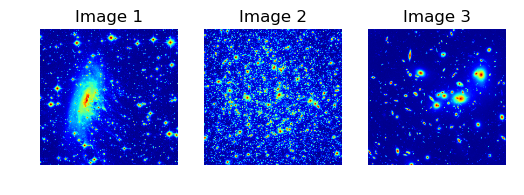

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(astro_images[0,])
ax1.set_title('Image 1')
ax1.axis('off') 
ax2 = fig.add_subplot(132)
ax2.imshow(astro_images[1,])
ax2.axis('off')
ax2.set_title('Image 2')
ax2 = fig.add_subplot(133)
ax2.imshow(astro_images[2,])
ax2.axis('off')
ax2.set_title('Image 3')
plt.show()

In [5]:
# [4096, 4]
spc = pyfits.open('../Data/spc_data.fits')[0].data
# [4096, 4]
spc_wavelets = pyfits.open('../Data/spc_data_wavelets.fits')[0].data
# [4, 4]
spc_mixmat = pyfits.open('../Data/spc_mixmat.fits')[0].data
# [4096, 4]
spc_sources = pyfits.open('../Data/spc_sources.fits')[0].data

/usr/local/lib/python3.4/dist-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (68416) is smaller than the expected size (69120)
  (self.size, pos))
/usr/local/lib/python3.4/dist-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (2944) is smaller than the expected size (5760)
  (self.size, pos))


In [6]:
spc.shape
print(spc_sources.shape)

(4096, 4)


# Pre-processing and principal component analysis

## Test whitening

In [7]:
np.random.seed(3)
test_data = np.random.rand(6, 10)
white_test_data, white_test_matrix = utils.whiten_data(test_data)

To verify that whitening was properly conducted, we compute the mean of each row and verify that the values are close to zero.

In [8]:
print(np.mean(white_test_data, axis=1))
whitened_cov = np.dot(white_test_data, white_test_data.T)
print(whitened_cov)
print('sum of differences between whitened cov and identity : {0}'.format(np.sum(whitened_cov - np.eye(whitened_cov.shape[0]))))

[  1.11022302e-17  -2.77555756e-18   1.44328993e-16   7.21644966e-17
   5.55111512e-18   7.77156117e-17]
[[  1.00000000e+00   1.41018371e-10   6.30521226e-11  -5.06395342e-11
    1.54863421e-10  -2.62581043e-10]
 [  1.41018371e-10   1.00000000e+00   3.47266799e-11  -3.45710335e-11
   -1.19050929e-10   8.97313612e-11]
 [  6.30521226e-11   3.47266799e-11   1.00000000e+00  -9.90004745e-11
    4.95695152e-11   1.79464221e-11]
 [ -5.06395342e-11  -3.45710335e-11  -9.90004745e-11   1.00000000e+00
   -1.00154343e-10  -1.44790541e-10]
 [  1.54863421e-10  -1.19050929e-10   4.95695152e-11  -1.00154343e-10
    9.99999999e-01   3.82585630e-11]
 [ -2.62581043e-10   8.97313612e-11   1.79464221e-11  -1.44790541e-10
    3.82585630e-11   9.99999999e-01]]
sum of differences between whitened cov and identity : -3.0831142049103644e-09


The means are indeed close to 0 (as the order of magnitude of the matrix value is 10^-1, and 10^-9 << 10^-1).

We also see that the covariance matrix is very close to the identity matrix.

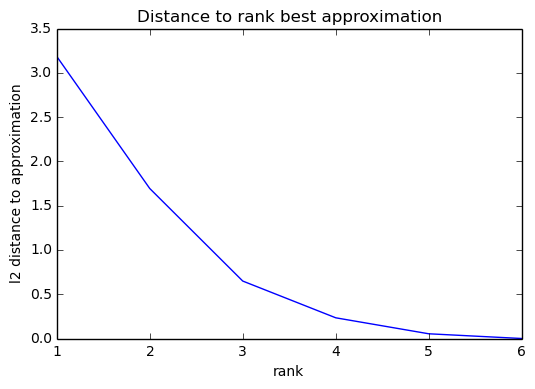

In [9]:
# Verify minimized value 
approx_vals = []
ranks = range(1, 7) 
for rank in ranks:
    rank_approx = utils.best_rank_n_approx(test_data, rank)
    rank_dist = np.sum((rank_approx - test_data)**2)
    approx_vals.append(rank_dist)
                       
plt.plot(ranks, approx_vals)
plt.title('Distance to rank best approximation')
plt.xlabel('rank')
plt.ylabel('l2 distance to approximation')
plt.show()

We see that the approximation becomes better as the maximum rank of the matrix increases. 

## PCA for Gaussian mixtures

In [10]:
mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=1, CdA=1, noise_level=120)

In [11]:
mixture_data.shape

(2, 1024)

In [12]:
pca_eigen_vecs, pca_data = pyBSS.Perform_PCA(mixture_data, 2)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


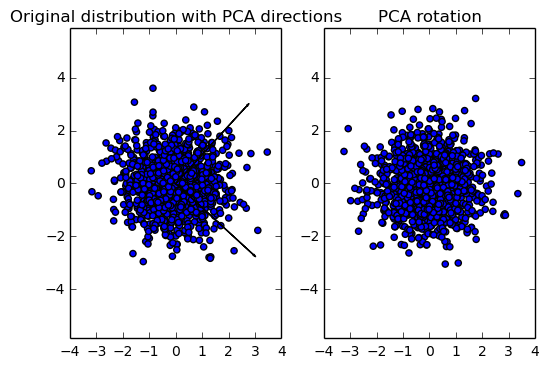

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.scatter(mixture_data[0,], mixture_data[1,])
# Show main PCA directions
ax1.arrow(0, 0, 4*pca_eigen_vecs[0, 0], 4*pca_eigen_vecs[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.arrow(0, 0, 4*pca_eigen_vecs[0, 1], 4*pca_eigen_vecs[1, 1], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.set_title('Original distribution with PCA directions')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.scatter(pca_data[0,], pca_data[1,])
ax2.set_title('PCA rotation')
ax2.axis('equal')
plt.show()

## Comments

We see that the PCA does not manage to extract significant informations from the original distribution. The rotation does not appear to find the relevant directions of the original distribution. This is due to the fact that the PCA finds the major variation directions. And in this case, there is no priviledged direction.

## fastICA results for mixture of uniform distributions

In [14]:
mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=2, CdA=1, noise_level=120)

In [15]:
Uy, Sy = pyBSS.Perform_FastICA(mixture_data, 2)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


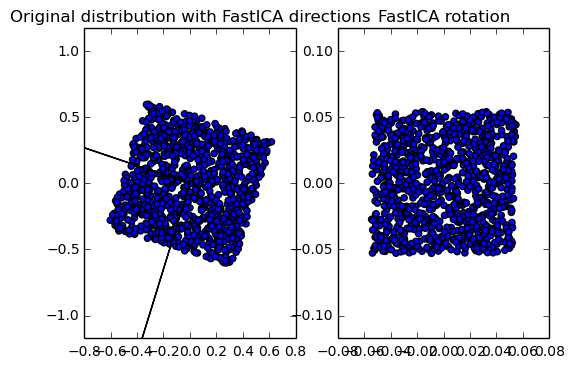

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.scatter(mixture_data[0,], mixture_data[1,])
# Show main PCA directions
ax1.arrow(0, 0, 4*Uy[0, 0], 4*Uy[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.arrow(0, 0, 4*Uy[0, 1], 4*Uy[1, 1], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.set_title('Original distribution with FastICA directions')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.scatter(Sy[0,], Sy[1,])
ax2.set_title('FastICA rotation')
ax2.axis('equal')
plt.show()

## Results

We see that the FastICA method works well for the uniform data as we manage to extract the direction of the square's axes. We manage to find the correct axes of the original distribution.

In [17]:
condition_nbs = [2,10,50,100]

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


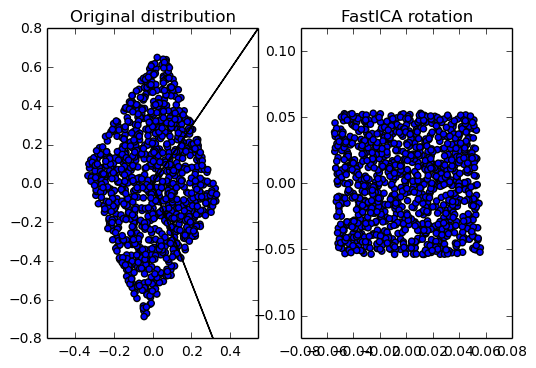

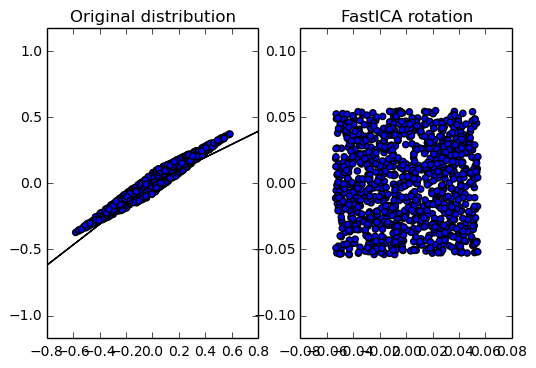

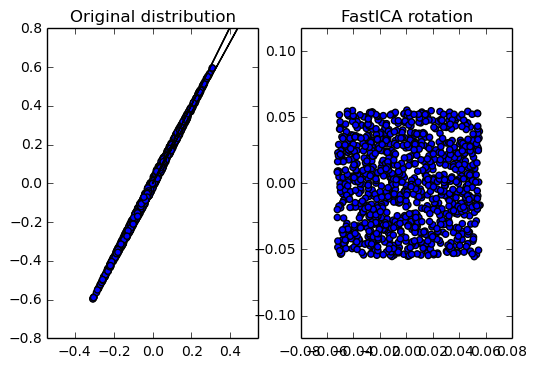

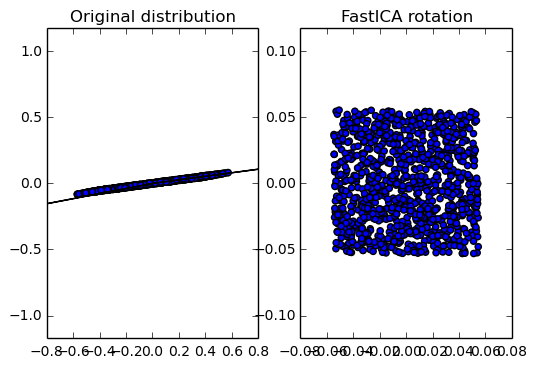

In [19]:
for condition_nb in condition_nbs:
    mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=2, CdA=condition_nb, noise_level=120)
    Uy, Sy = pyBSS.Perform_FastICA(mixture_data, 2)
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.scatter(mixture_data[0,], mixture_data[1,])
    # Show main PCA directions
    ax1.arrow(0, 0, 4*Uy[0, 0], 4*Uy[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
    ax1.arrow(0, 0, 4*Uy[0, 1], 4*Uy[1, 1], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
    ax1.set_title('Original distribution')
    ax1.axis('equal')
    ax2 = fig.add_subplot(122)
    ax2.scatter(Sy[0,], Sy[1,])
    ax2.set_title('FastICA rotation')
    ax2.axis('equal')
    plt.show()

As we saw it during the 6th class, fastICA has the property of equivariance : the convergence performances of this algorithm does not depend on the condition number of the initial matrix. We therefore see that the quality of the source estimation does not depend on the condition number.

## Application to IRM chandra data

In [20]:
chandra_data = scipy.io.loadmat('../Data/chandra.mat')

In [21]:
chandra_content_a = chandra_data['A0']
chandra_content_s = chandra_data['S0']
print(chandra_content_a.shape)
print(chandra_content_s.shape)
chandra_mixed = np.dot(chandra_content_a, chandra_content_s)

(107, 8)
(8, 7396)


In [22]:
chandra_mixing_matrix, chandra_sources = pyBSS.Perform_FastICA(chandra_mixed, 8)

In [24]:
fastICA_chandra_score = pyBSS.Eval_BSS(chandra_mixing_matrix, chandra_content_s,
                                       chandra_content_a, chandra_sources)

print('chandra reconstruction score : {0}'.format(fastICA_chandra_score))

chandra reconstruction score : 0.12714976966869873


We see that the reconstruction with fastICA works pretty well on the chandra dataset, as the reconstruction score is pretty low.

## GMCA (Generalized Morphological Component Analysis)

Sources are sparse in a non-necessarily orthogonal representation.
GMCA is an iterative algorithm that updates at each iteration the sources and the mixing matrix.

Unlike FastICA GMCA has no orthogonality constraint.

In [25]:
np.random.seed(1)
mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=2, CdA=1, noise_level=120)
estimate_mixture, sources, PinvA = pyBSS.Perform_GMCA(mixture_data, 2, nmax=250, mints=1, maxts=0)

In [29]:
gmca_uniform_score = pyBSS.Eval_BSS(mixture_matrix, mixture_sources,
                                    estimate_mixture, sources)

print('GMCA reconstruction score on uniform distribution : ', gmca_uniform_score)

GMCA reconstruction score on uniform distribution :  0.934556691964


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


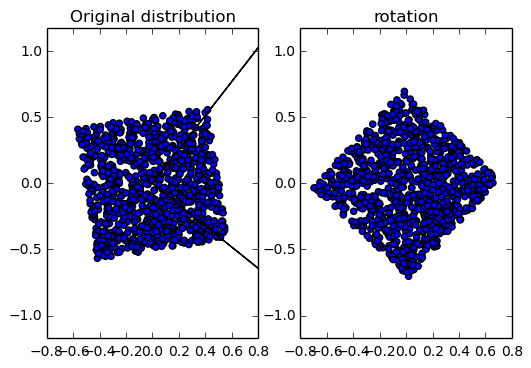

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.scatter(mixture_data[0,], mixture_data[1,])
# Show main PCA directions
ax1.arrow(0, 0, 4*estimate_mixture[0, 0], 4*estimate_mixture[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.arrow(0, 0, 4*estimate_mixture[0, 1], 4*estimate_mixture[1, 1], head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
ax1.set_title('Original distribution')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.scatter(sources[0,], sources[1,])
ax2.set_title('rotation')
ax2.axis('equal')
plt.show()

We can see that the GMCA rotated the data to make them as sparse as possible according to the l1 norm. Therefore, we do not retrieve the square shape of the initial sources at all. We do not retrieve the original directions for the random variables.  The visual observation is coherent with the low evaluation score.

## GMCA with noise

In [31]:
signal_noise_ratios = [40, 30, 20, 10]

noise level :  100


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


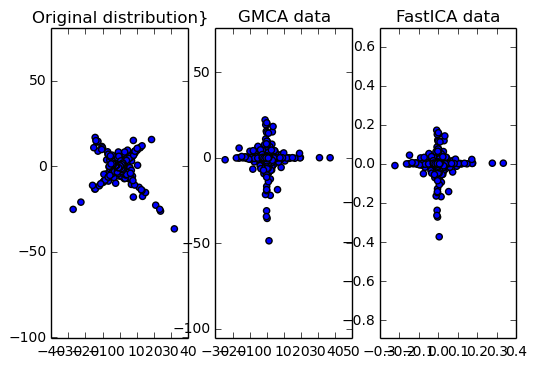

noise level :  70


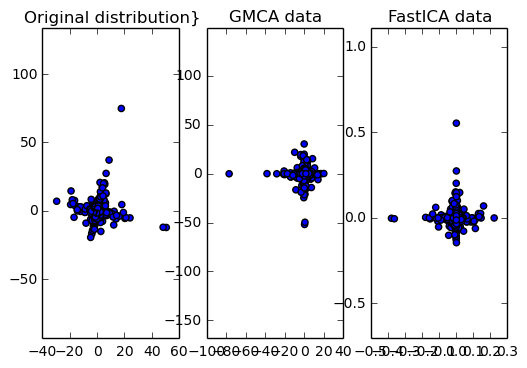

noise level :  40


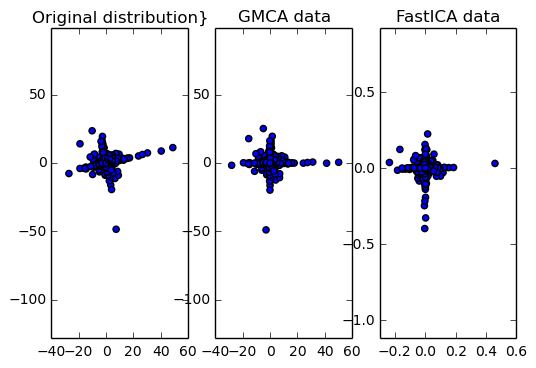

noise level :  30


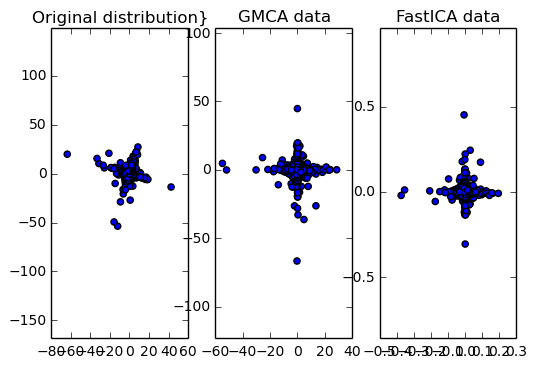

noise level :  20


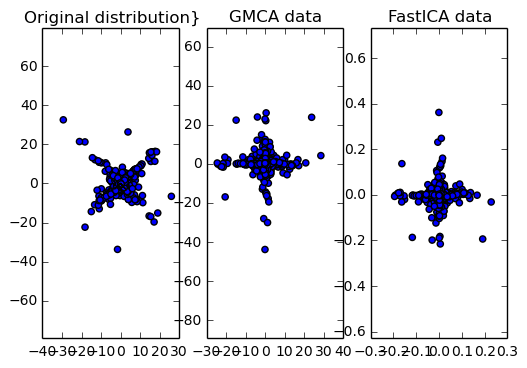

noise level :  10


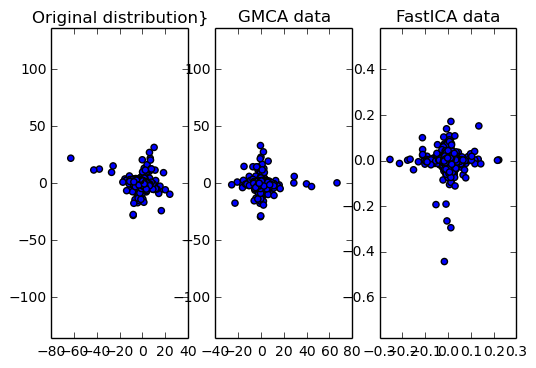

In [82]:
for signal_noise_ratio in signal_noise_ratios:
    mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=3,
                                                                          CdA=1, noise_level=signal_noise_ratio)
    mixing_matrix_gmca_estimation, sources_gmca_estimation, PinvA = pyBSS.Perform_GMCA(mixture_data, 2, nmax=250, mints=1, maxts=0)
    mixing_matrix_fastica_estimation, sources_fastica_estimation = pyBSS.Perform_FastICA(mixture_data, 2)
    print('noise level : ', signal_noise_ratio)
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.scatter(mixture_data[0,], mixture_data[1,])
    # Show main PCA directions
    ax1.arrow(0, 0, 4*mixing_matrix_gmca_estimation[0, 0], 4*mixing_matrix_gmca_estimation[1, 0],
              head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
    ax1.arrow(0, 0, 4*mixing_matrix_gmca_estimation[0, 1], 4*mixing_matrix_gmca_estimation[1, 1],
              head_width=0.05, head_length=0.1, fc='k', ec='k', color='red')
    ax1.set_title('Original distribution}')
    ax1.axis('equal')
    ax2 = fig.add_subplot(132)
    ax2.scatter(sources_gmca_estimation[0,], sources_gmca_estimation[1,])
    ax2.set_title('GMCA data')
    ax2.axis('equal')
    ax3 = fig.add_subplot(133)
    ax3.scatter(sources_fastica_estimation[0,], sources_fastica_estimation[1,])
    ax3.axis('equal')
    ax3.set_title('FastICA data')
    plt.show()

As we decrease the signal to noise ratio, the data is more and more corrupted by noise and it becomes more and more difficult to find the two directions that account for the sparsity of the original signal. Nevertheless, visually the results seem satisfying both for fastICA and GMCA. Let's take a look at the numerical results.

In [74]:
def evaluate_reconstruction_gmca(noise_level, iterations):
    eval_values = []
    for it in range(iterations):
        # Ground truth
        mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=3,
                                                                              CdA=1, noise_level=noise_level)
        # Reconstruct
        mixing_matrix_reconstruct, sources_reconstruct, PinvA = pyBSS.Perform_GMCA(mixture_data, n=2,
                                                                                   nmax=250, mints=1, maxts=0) 
        eval_value = pyBSS.Eval_BSS(mixture_matrix, mixture_sources,
                                    mixing_matrix_reconstruct, sources_reconstruct)
        eval_values.append(eval_value)
    return np.mean(eval_values)

def evaluate_reconstruction_fastica(noise_level, iterations):
    eval_values = []
    for it in range(iterations):
        # Ground truth
        mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=3,
                                                                              CdA=1, noise_level=noise_level)
        # Reconstruct
        mixing_matrix_reconstruct, sources_reconstruct = pyBSS.Perform_FastICA(mixture_data, 2) 
        eval_value = pyBSS.Eval_BSS(mixture_matrix, mixture_sources,
                                    mixing_matrix_reconstruct, sources_reconstruct)
        eval_values.append(eval_value)
    return np.mean(eval_values)
    

In [75]:
signal_noise_ratios = [100, 70, 40, 30, 20, 10]
noise_gmca_perfs = []
mean_fastica_perfs = []
for signal_noise_ratio in signal_noise_ratios:
    mean_gmca_perf = evaluate_reconstruction_gmca(signal_noise_ratio, 50)
    noise_gmca_perfs.append(mean_gmca_perf)
    mean_fastica_perf = evaluate_reconstruction_fastica(signal_noise_ratio, 50)
    mean_fastica_perfs.append(mean_fastica_perf)

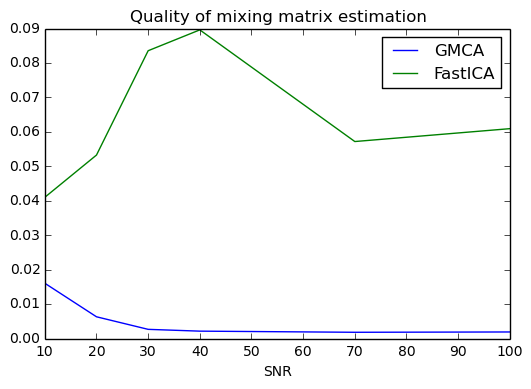

In [76]:
plt.plot(signal_noise_ratios, noise_perfs)
plt.plot(signal_noise_ratios, mean_fastica_perfs)
plt.title('Quality of mixing matrix estimation')
plt.xlabel('SNR')
plt.legend(['GMCA', 'FastICA'])
plt.show()

As expected, we see that as the Signal to noise ratio increases,  for the GMCA, the quality of the estimation of the mixing matrix increases as well. We averaged the results of 50 iterations for each SNR to obtain a more relevant estimation of the SNR score. The numerical results are pretty low which confirms the quality of the reconstruction. 

The performances of fastICA is worse then GMCa but seems to be less systematically affected by noise.

## pALS

I decided to code the **projected Alternating Least Square (pALS)** method.
For this, we iteratively perform the two following steps :

- approximate the source (assuming the mixing matrix is known)

- approximate the mixing matrix (assuming the sources are known)

The algorithm can therefore be summed up as following :

- initialize the mixing matrix randomly

- compute an estimation of the sources $\hat{S}$ by multiplying the Moore Penrose pseudo-inverse of the mixing matrix with the mixed data $X$ and soft thresholding the results

$$\hat{S} = S_{\lambda}(\hat{A}^+X)$$

-  multiply the mixed data by the Moore Penrose pseudo-inverse of the sources

$$\hat{A} = X\hat{S}^+$$




In [111]:
def perform_pals(mixed_data, source_nb=2, threshold=100, iterations=100):
    observation_nb, channel_nb = np.shape(mixed_data)
    mixing_matrix = np.random.randn(observation_nb, source_nb) + 1
    if(iterations>0):
        for it in range(iterations):
            # Source projection
            pinv_mixing_matrix = np.linalg.pinv(mixing_matrix)
            sources = utils.soft_thresholding(np.dot(pinv_mixing_matrix, mixed_data), threshold)

            # Mixing matrix projection
            pinv_sources = np.linalg.pinv(sources)
            mixing_matrix = np.dot(mixed_data, pinv_sources)
    else:
        sources = np.random.randn(source_nb, channel_nb)
    return mixing_matrix, sources

In [112]:
np.random.seed(4)
mixture_data, mixture_matrix, mixture_sources = pyBSS.GenerateMixture(n=2, t=1024, m=2, p=0.02, SType=3,
                                                                              CdA=1)

In [113]:
np.random.seed(6)
estimated_mixing_matrix, estimated_sources = perform_pals(mixture_data, source_nb=2, threshold=1, iterations=8)

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


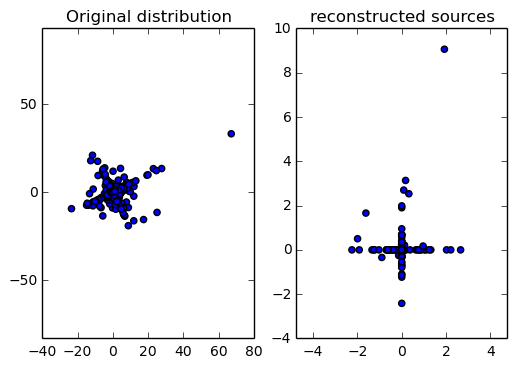

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.scatter(mixture_data[0,], mixture_data[1,])
ax1.set_title('Original distribution')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.scatter(estimated_sources[0,], estimated_sources[1,])
ax2.set_title('reconstructed sources')
ax2.axis('equal')
fig.show()

In [115]:
reconstruct_score = pyBSS.Eval_BSS(mixture_matrix, mixture_sources,
                                   estimated_mixing_matrix, estimated_sources)

print('reconstruction score : {0}'.format(reconstruct_score))

reconstruction score : 0.11118883674541369


We see that the score is lower then in the simulated case with 2 sparse sources for the pALS algorithm then for the GMCA algorithm. Still, in the simplified case the score is not too bad and we see that we managed to find the two major directions of the distribution.

In [116]:
reconstr_scores = []
for it in range(0, 10):
    np.random.seed(6)
    estimated_mixing_matrix, estimated_sources = perform_pals(mixture_data, source_nb=2, threshold=1, iterations=it)
    reconstruct_score = pyBSS.Eval_BSS(mixture_matrix, mixture_sources,
                                   estimated_mixing_matrix, estimated_sources)
    reconstr_scores.append(reconstruct_score)

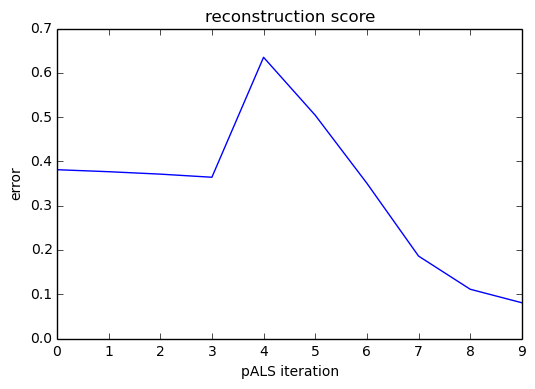

In [117]:
plt.plot(reconstr_scores)
plt.title('reconstruction score')
plt.ylabel('error')
plt.xlabel('pALS iteration')
plt.show()

We see that after some initial instability the score starts to decrease with the interations. 

Trying with other random seeds we see that the behaviour of this algorithm is very unstable. I am not sure whether it is caused by errors in my implementation.

## Chandra data

Now let us try to apply the algorithm to the more complex and not strictly conjointly sparse Chandra data

In [118]:
np.random.seed(4)
pals_chandra_scores = []
gmca_chandra_scores = []
for it in range(50):
    chandra_pals_mixing_matrix, chandra_pals_sources = perform_pals(chandra_mixed, source_nb=8,
                                                                          threshold=1, iterations=8)
    chandra_gmca_mixing_matrix, chandra_gmca_sources, pinv = pyBSS.Perform_GMCA(chandra_mixed, 8)
    pals_chandra_score = pyBSS.Eval_BSS(chandra_pals_mixing_matrix, chandra_content_s,
                                    chandra_mixing_matrix, chandra_pals_sources)
    pals_chandra_scores.append(pals_chandra_score)
    gmca_chandra_score = pyBSS.Eval_BSS(chandra_gmca_mixing_matrix, chandra_content_s,
                                    chandra_mixing_matrix, chandra_gmca_sources)
    gmca_chandra_scores.append(gmca_chandra_score)

/mnt/c/Users/Yana/OneDrive - CentraleSupelec/Cours/Semester2/MVA/astro/TP3/Codes/src/pyBSS.py:406: RuntimeWarning: invalid value encountered in true_divide
  Diff[ns, :] = abs(Diff[ns, :]) / max(abs(Diff[ns, :]))


In [121]:
print('pALS score on chandra data : ', np.mean(pals_chandra_scores))
gmca_chandra_scores = np.asarray(gmca_chandra_scores)
print('GMCA score on chandra data : ', gmca_chandra_scores[~np.isnan(gmca_chandra_scores)].mean())

pALS score on chandra data :  0.317706363158
GMCA score on chandra data :  0.192880015882


This result is pretty bad especially for the pALS, compared to FastICA for instance (but it is still significantly better then a random mixing matrix, *see last paragraph*). Overall both algorithms provide relatively poor results. For pALS, this might be due to an error in our algorithm. Otherwise, it is most probably because chandra's data is not conjointly sparse. Therefore the sparse hypothesis is not sustained, and sometimes coefficients are important for different sources at the same time. The estimated sparse solution and the true solution are therefore different, which, beside the unstability of the algorithm, affects the quality of the estimation.

I bring to attention the fact that we have operated the soft thresholding in the domain in which the data was provided, I am not sure what exactly the nature of the chandra data is (beside the fact that it is related to IRM data). The thresholding should be conducted in a base in which the sources are sparse. In this case I am not sure what such a base would be.

We could also have used a decreasing threshold to try to not attenuate to much the original sources while removing irrelevant data such as noise.

In [58]:
reconstr_scores = []
for it in range(1, 10):
    np.random.seed(5)
    estimated_mixing_matrix, estimated_sources = perform_pals(chandra_mixed, source_nb=8, threshold=1, iterations=it)
    reconstruct_score = pyBSS.Eval_BSS(chandra_content_a, chandra_content_s,
                                   estimated_mixing_matrix, estimated_sources)
    reconstr_scores.append(reconstruct_score)

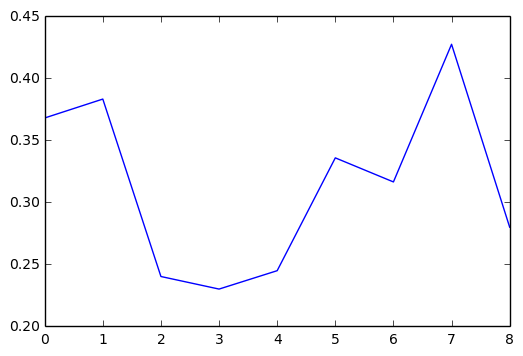

In [59]:
plt.plot(reconstr_scores)
plt.show()

We see that the results are pretty unstable and we do not obtain a monotonical decrease towards a better mixing matrix. Let's compare those results to random mixing matrices to see if we produce at least better then random results.

## Random mixing matrix evaluation on chandra data for comparison

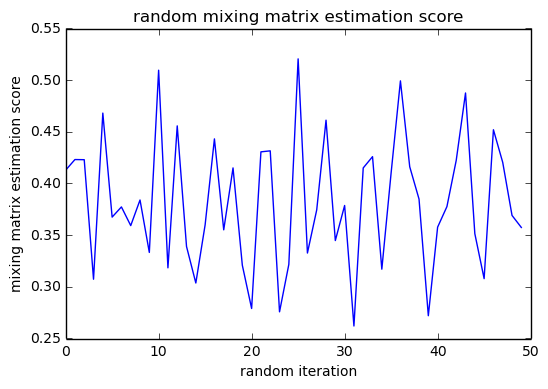

mean of average score for random matrix scores 0.38270176907


In [109]:
random_scores = []
for i in range(50):
    estimated_chandra_mixing_matrix = np.random.randn(107 ,8)
    random_score = pyBSS.Eval_BSS(estimated_chandra_mixing_matrix, chandra_content_s,
                                  chandra_mixing_matrix, estimated_chandra_sources)
    random_scores.append(random_score)
    
plt.plot(random_scores)
plt.title('random mixing matrix estimation score')
plt.xlabel('random iteration')
plt.ylabel('mixing matrix estimation score')
plt.show()
print('mean of average score for random matrix scores', np.mean(random_scores) )

With our implementation, we seem to consistently find better-then-random mixing matrices for the chandra dataset.